In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns
%matplotlib inline

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
import math 
import ast
from tabulate import tabulate
from scipy.stats.stats import pearsonr
from scipy.stats import mode

def split_line(line):
    loss = float(line.split('loss: ')[1].split(',')[0])
    auc = float(line.split('auc: ')[1].split(',')[0])
    params = ast.literal_eval(line.split('params: ')[1])
    return [loss, auc, params]


def parse_file(files, sort_by_loss=True):
    results = []
    
    for filename in files:
        with open(filename, 'r') as fp:
            for line in fp:
                results.append(split_line(line.strip()))

    if sort_by_loss:
        results = sorted(results)
    else:
        results = sorted(results, key=lambda x: -x[1])

    lr = []
    reg = []
    width = []
    length = []
    dropout = []
    loss = []
    auc = []
    decay = []
    for result in results:
        loss.append(result[0])
        auc.append(result[1])
        lr.append(result[2]['lr'])
        reg.append(result[2]['reg'])
        
    loss = np.array(loss)
    auc = np.array(auc)
    lr = np.array(lr)
    decay = np.array(decay)
    reg = np.array(reg)
    width = np.array(width)
    length = np.array(length)
    dropout = np.array(dropout)
      
    results = {
        'loss': loss,
        'auc': auc,
        'lr': lr,
        'reg': reg
    }
    
    print('')
    return results


def results_stats(results, top=1, relative=True):
    headers = ['metric', 'min', 'max', 'median', 'mean', 'std']    
    results_stats = []
    results_logstats = []
    
    top_results = dict()
    for i, key in enumerate(results):
        arr = results[key]
        if relative:
            idx = math.ceil(top*len(arr))
        else:
            idx = top
        arr = arr[:idx]
        top_results[key] = arr
        results_stats.append([key, arr.min(), arr.max(), np.median(arr), arr.mean(), arr.std()])
        
        if i == 0:
            samples = len(arr)
        
        if key in log_metrics:
            logarr = np.log10(arr)
            results_logstats.append([key, logarr.min(), logarr.max(), 
                                     np.median(logarr), logarr.mean(), logarr.std()])
            
    print('# samples = %d/%d' % (samples, len(results[key])))
    print (tabulate(results_stats, headers=headers, numalign="right", floatfmt=".10f"))
    print('\n\nlog metrics')
    print (tabulate(results_logstats, headers=headers, numalign="right", floatfmt=".10f"))
    
    return results_stats, top_results


def plot_hist(results):
    plt.figure(figsize=(12, 12))
    ncol = 3
    nrow = math.ceil(len(results) / ncol) 
        
    for i, key in enumerate(results):
        plt.subplot(nrow, ncol, i + 1)
        if key in log_metrics:
            arr = np.log10(results[key])
            label = 'log' + key
        else:
            arr = results[key]
            label = key
        
        max = arr.max()
        min = arr.min()
        bins = np.linspace(min, max, 15)
        plt.hist(arr, bins=bins)
        plt.xlabel(label)
        plt.ylabel('freq')
        
        
def print_best(results, k=1):
    best_result = []
    headers = []
    
    for i in range(k):
        best_result.append([])
        for key in results:
            if key in log_metrics:
                best_result[-1] += [np.log10(results[key][i])]
                if i == 0:
                    headers += ['log' + key]
            else:
                best_result[-1] += [results[key][i]]
                if i == 0:
                    headers += [key]

    print('\nbest models')
    print (tabulate(best_result, headers=headers, numalign="right", floatfmt=".6f"))
    print()
    
    
def plot_scatter(results, metric='loss'):
    plt.figure(figsize=(12, 12))
    ncol = 3
    nrow = math.ceil(len(results) / ncol) 
    
    count = 1
    for key in results:
        if key != metric:
            plt.subplot(nrow, ncol, count)
            if key in log_metrics:
                arr = np.log10(results[key])
                label = 'log' + key
            else:
                arr = results[key]
                label = key

            plt.scatter(arr, results[metric])
            plt.xlabel(label)
            plt.ylabel(metric)
            count += 1
        
        
def get_model_name(results, top=5):
    names = []
    for i in range(top):
        name = 'model.' \
            + 'auc:%.6f.' % results['auc'][i] \
            + 'lr:%.6f.' % results['lr'][i] \
            + 'reg:%.6f.' % results['reg'][i] 
        names += [name]
        
    return names


def compare_plots(results, keys, top=10):
    plt.figure(figsize=(15, 6))
    marker_size = 20
    
    # loss
    plt.subplot(1, 2, 1)
    colors = results['loss'][:top]
    x_scatter = results[keys[0]][:top]
    xlabel = keys[0]
    if keys[0] in log_metrics:
        x_scatter = np.log10(x_scatter)
        xlabel = 'log' + xlabel
    
    y_scatter = results[keys[1]][:top]
    ylabel = keys[1]
    if keys[1] in log_metrics:
        y_scatter = np.log10(y_scatter)
        ylabel = 'log' + ylabel
    
    plt.scatter(x_scatter, y_scatter, marker_size, cmap='inferno', c=colors)
    plt.colorbar()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title('loss')
    
    # auc
    plt.subplot(1, 2, 2)
    colors = results['auc'][:top]
    plt.scatter(x_scatter, y_scatter, marker_size, cmap='inferno', c=colors)
    plt.colorbar()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title('auc')

    
def topology_hist(results, metric='loss'):
    keys = ['width', 'length']
    plt.figure(figsize=(16, 6))
    max = results[metric].max()
    min = results[metric].min()
    bins = np.linspace(min, max, 7)    
    for i, key in enumerate(keys):
        for value in np.unique(results[key]):
            plt.subplot(1, 2, i + 1)
            plt.hist(results[metric][results[key] == value], label=key+'='+str(value), bins=bins)
        plt.xlabel(metric)
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
          ncol=5, fancybox=True, shadow=True)
        plt.xlim([0.99*min, 1.01*max])
        
        if i == 0:
            plt.ylabel('freq')
            
log_metrics = ['lr', 'decay', 'reg']

In [3]:
files = ['../logistic_results.log']   
results = parse_file(files, sort_by_loss=False)

top = 9
print('Correlation loss x AUC: (%.6f, %.6e)' % pearsonr(results['auc'], results['loss']))
print_best(results, top)
_, top_results = results_stats(results, top, relative=False)


Correlation loss x AUC: (-0.558373, 1.156607e-25)

best models
    loss       auc      loglr     logreg
--------  --------  ---------  ---------
0.175402  0.982722  -1.748540  -1.463563
0.185312  0.982363  -2.030975  -1.633657
0.177334  0.982264  -1.700104  -1.332410
0.171649  0.982234  -1.796798  -1.536327
0.171012  0.982058  -1.705004  -1.527232
0.174568  0.981947  -1.727867  -1.773814
0.178233  0.981876  -1.894899  -1.652703
0.178313  0.981828  -1.711504  -1.422260
0.169155  0.981648  -1.892557  -1.661046

# samples = 9/296
metric             min           max        median          mean           std
--------  ------------  ------------  ------------  ------------  ------------
loss      0.1691549200  0.1853117900  0.1754017800  0.1756640611  0.0046054394
auc       0.9816475600  0.9827224600  0.9820583300  0.9821045478  0.0003083433
lr        0.0093116063  0.0199478587  0.0178426809  0.0162756508  0.0036035184
reg       0.0168339336  0.0465147267  0.0290852935  0.0290739744  0.008

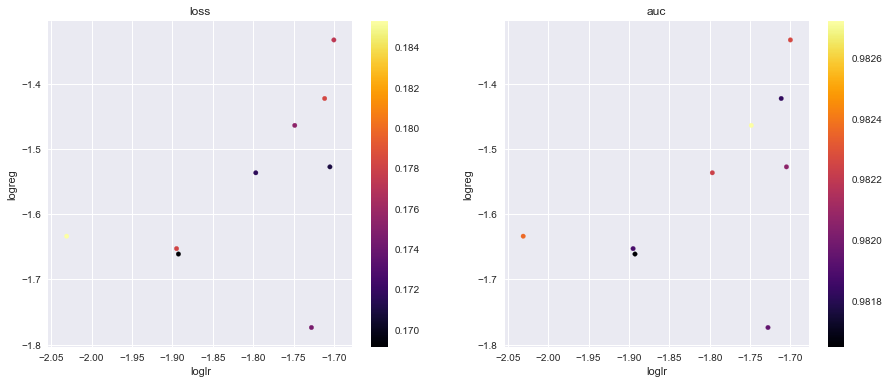

In [4]:
compare_plots(results, ['lr', 'reg'], top)

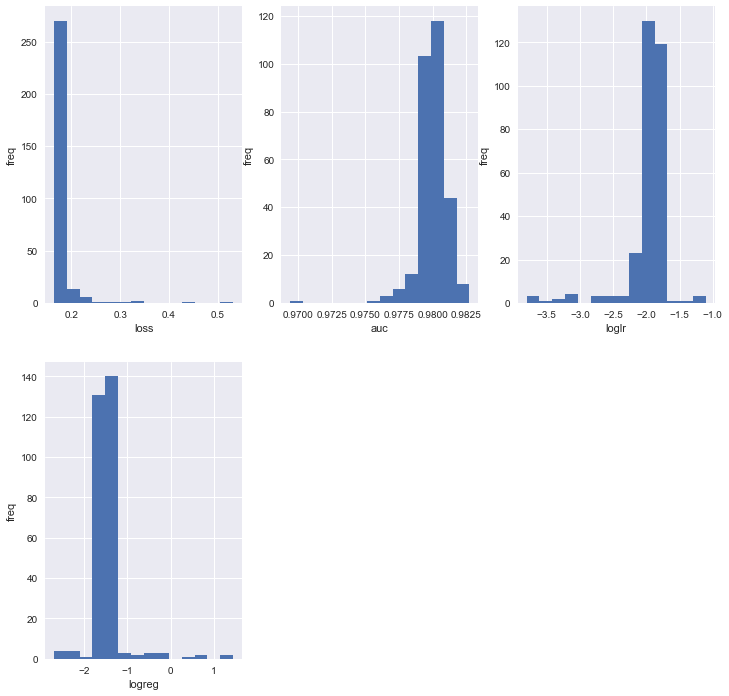

In [5]:
plot_hist(results)

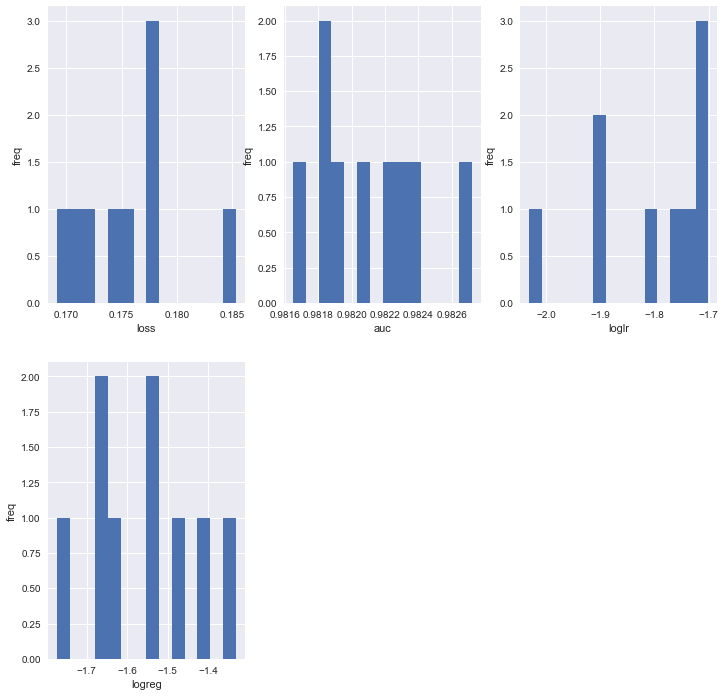

In [6]:
plot_hist(top_results)

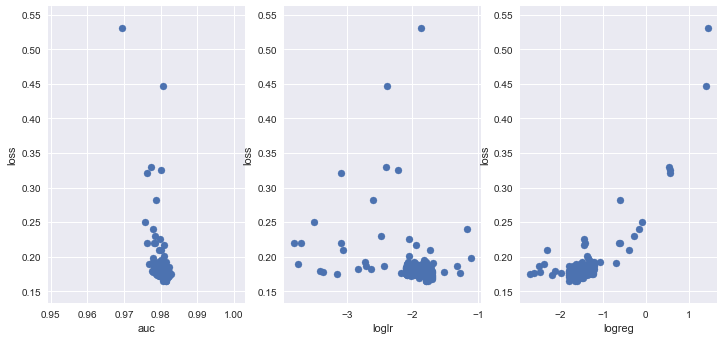

In [7]:
plot_scatter(results, 'loss')

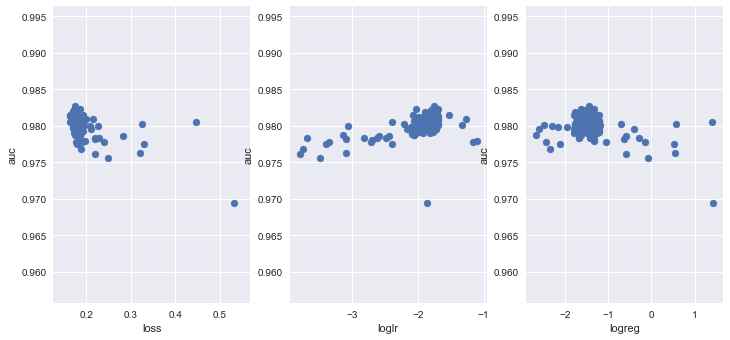

In [8]:
plot_scatter(results, 'auc')

../logistic_history/model.auc:0.982363.lr:0.009312.reg:0.023246.pickle


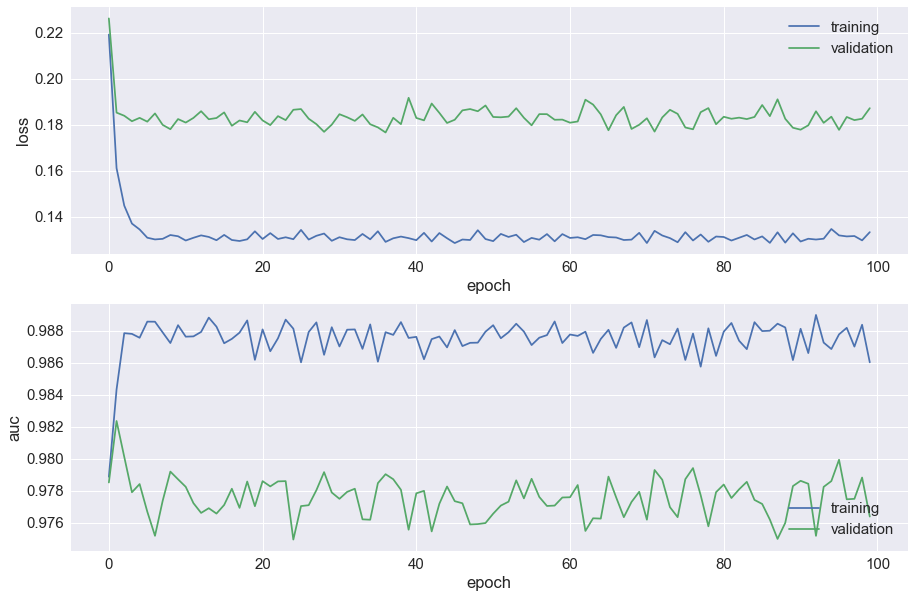

In [14]:
import pickle
def plot_evolution(scores_train, scores_val, metric, loc=None):
    plt.figure(figsize=(15, 10))
    ax = plt.subplot(2, 1, 1)
    plt.plot(scores_train['loss'], label='training')
    plt.plot(scores_val['loss'], label='validation')
    #plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc="upper right")
    plt.subplot(2, 1, 2, sharex=ax)
    plt.plot(scores_train['auc'], label='training')
    plt.plot(scores_val['auc'], label='validation')
    plt.xlabel('epoch')
    plt.ylabel('auc')
    plt.legend(loc="lower right")


filename = '../logistic_history/model.auc:0.982363.lr:0.009312.reg:0.023246.pickle'
print(filename)
with open(filename, 'rb') as handle:
    [scores_train, scores_val] = pickle.load(handle)
plt.figure()

sns.set(font_scale=1.5)
plot_evolution(scores_train, scores_val, 'auc')